# DnD Challenge Rating Prediction & Calculation

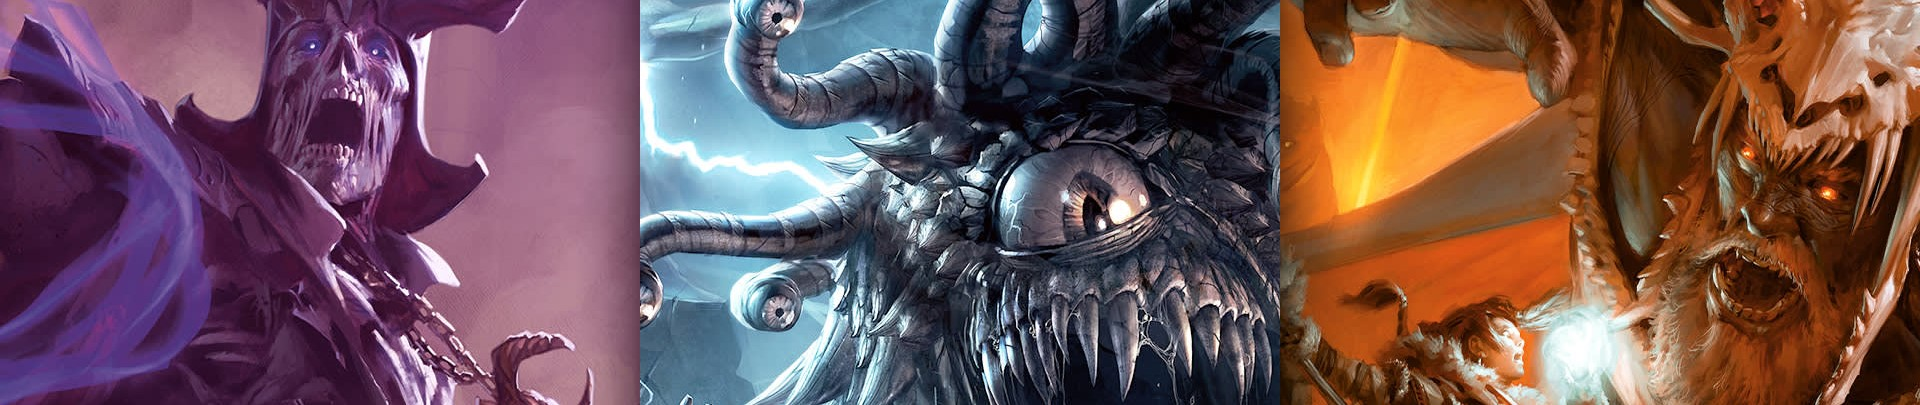

# Overview

This project uses an iterative approach to Regression Modelling in order to understand how a Home-brew Dungeon & Dragon's Monster stats may effect it's Challenge Rating (CR). With increasing popularity surrounding the Tabletop RPG, D&D Beyond can use this Prediction Model to calculate the CR of any Home-brew Monster to a 91% accuracy and once implmented into their Website, can provide a CR Calculation/Prediction tool for the increasing player base.

# Business Problem

[D&D Beyond](https://www.dndbeyond.com) is one of the most popular online Dungeon and Dragons platforms for players all over the world. It has hundreds of pages of information on the Tabletop Game and it's rules, as well as many Tools for players to use, such as;
- Creating a character,
- Organising a campaign, 
- Designing character made (or Home-brew) Monsters.
  
In order to complete a Home-brew Monster, the tool requires the player to input it's Challenge Rating (referred to as CR), which is a numbered indication of how difficult the Monster may be to defeat. However, there is no tool within D&D Beyond itself to do this, and online research finds that the calculation of CR is quite a mystifying problem, especially for people that are new to the game. 

With increasing popularity over the past 5 years, and a new D&D movie on the horizon, a wave of new players may be on the way. Therefore, it is of D&D Beyond's benefit to produce a CR calculator that can be implemented into the website in preparation for this influx. This project aims to provide such a tool that can use the stats of any Home-brew Monster, and output a CR that is appropriate and suitable, based upon a prediction model using Official Monster stats.

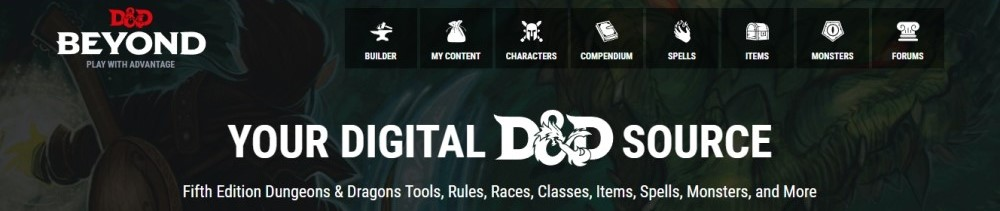

# Data Understanding

The data sourced for this regression analysis comes from [Kaggle](https://www.kaggle.com/datasets/travistyler/dnd-5e-monster-manual-stats), which has been API scraped from an online version of the Official 5th Edition Dungeon & Dragons Compendium available at [AideDD](https://www.aidedd.org/dnd-filters/monsters.php).  
  
This data-set includes 762 different D&D Monsters, with 53 columns on their details. It provided insight into not only their base stats such as Health Points (HP) and Armour Class (AC), but also information on their Action and Attack abilities.

In [1]:
import pandas as pd
df = pd.read_csv('data/aidedd_blocks2.csv')
df.head()

,name,size,type,alignment,languages,ac,hp,cr,speed,swim,...,religion,acrobatics,athletics,intimidation,senses,attributes,actions,legendary_actions,legendary,source
0,aarakocra,medium,humanoid (aarakocra),neutral good,"Auran, Aarakocra",12.0,13,0.25,20,0,...,0,0,0,0,passive Perception 15,Dive Attack. If the aarakocra is flying and di...,"Talon. Melee Weapon Attack: +4 to hit, reach 5...",none,0,Monster Manual (BR)
1,abjurer,medium,humanoid (any race),any alignment,any four languages,12.0,84,9.00,30,0,...,0,0,0,0,passive Perception 11,unavailable,unavailable,unavailable,0,Volo's Guide to Monsters
2,aboleth,large,aberration,lawful evil,"Deep Speech, telepathy 120 ft.",17.0,135,10.00,10,40,...,0,0,0,0,"darkvision 120 ft., passive Perception 20",Amphibious. The aboleth can breathe air and wa...,Multiattack. The aboleth makes three tentacle ...,"The aboleth can take 3 legendary actions, choo...",1,Monster Manual (SRD)
3,abominable-yeti,huge,monstrosity,chaotic evil,Yeti,15.0,137,9.00,40,0,...,0,0,0,0,"darkvision 60 ft., passive Perception 15",unavailable,unavailable,unavailable,0,Monster Manual
4,acererak,medium,undead,neutral evil,"Abyssal, Common, Draconic, Dwarvish, Elvish, G...",21.0,285,23.00,30,0,...,15,0,0,0,"truesight 120 ft., passive Perception 22",unavailable,unavailable,unavailable,0,Adventures (Tomb of Annihilation)


Through exploration, it was noted that CR was not normally distributed, with a higher Challenge Rating being more rare, and that HP had a very similar distribution.

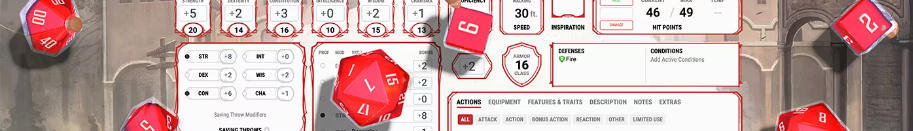

# Data Preparation & Cleaning

Thankfully, as D&D is a maths and number based tabletop RPG, many of the desired columns were already integers, including the Monster's stat scores;
- Stregth (`str`)
- Dexterity (`dex`)
- Constitution (`con`)
- Intelligence (`intel`)
- Wisdom (`wis`)
- Charisma (`cha`)
  
As well as it's movement `speed`, such as walking, flying and swimming.  

In [2]:
df = pd.read_csv('data/Final_Monster_Data.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,size,type,ac,hp,cr,speed,swim,fly,strength,dex,con,intel,wis,cha,legendary,multiattack
0,medium,humanoid,12.0,13,0.25,20,0,50,10,14,10,11,12,11,0,0
1,medium,humanoid,12.0,84,9.00,30,0,0,9,14,14,18,12,11,0,0
2,large,aberration,17.0,135,10.00,10,40,0,21,9,15,18,15,18,1,1
3,huge,monstrosity,15.0,137,9.00,40,0,0,24,10,22,9,13,9,0,0
4,medium,undead,21.0,285,23.00,30,0,0,13,16,20,27,21,20,0,0


Null values were filled with the 'unavailable' place-marker in the `actions` column, and a feature category was made to show which Monster's had the `Multiattack` ability, which enables the creature to attack more than once per action round.  

Similarly, the `Legendary` column shows if a Monster has legendary actions, which are usually attacks or spell-casting abilities that can be taken outside of a creature's turn.   

It was also noted that the columns of `size` and `type` were categorical, and the sub-types within parenthesises of the `type` column were removed to reduce the unique values down to the basic 15.

# Regression Modelling

To ensure accuacy of the models prediction and therefore calculation properties, the data-frame was split into a train and test sections. Due to it's fairly small nature, the split uses the default 75/25 ratio. The 'stratify' feature was used in this split for the `type` column, as some of the Monster species only had 8 individual rows attributed to them.

In [3]:
df['type'].value_counts()

humanoid       189
beast          105
fiend           89
monstrosity     87
undead          50
dragon          47
elemental       38
aberration      37
giant           27
plant           24
construct       24
fey             21
swarm            8
celestial        8
ooze             8
Name: type, dtype: int64

## Model 1

The first iteration of the model was to be a simple base-line that could be built-up and extrapolated upon. Looking at some of the highest correlated features to the dependent feature of `cr`, the independent features chosen were `hp`, `con` and `ac`.

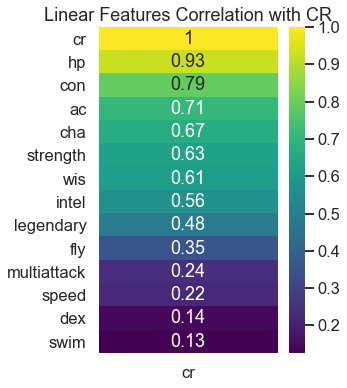

In [4]:
import IPython.display as display
display.Image('Images/Lin_FeaturesvsCR.png')

Using SkLearn's Linear Regression, this simple base model provided a decent line of fit, with an R2 score of 0.87 for both the train/test split and R Adjusted, and a RMSE of 2.2.

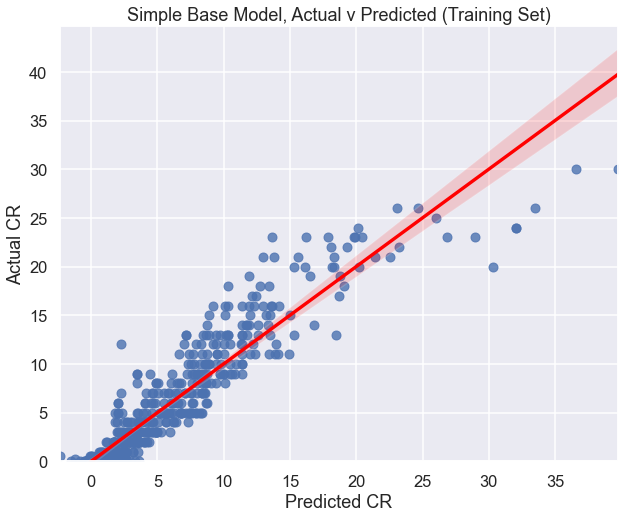

In [5]:
display.Image('Images/Base_model.png')

The model however did show potential Skew and Kurtosis within it's qq-plot.

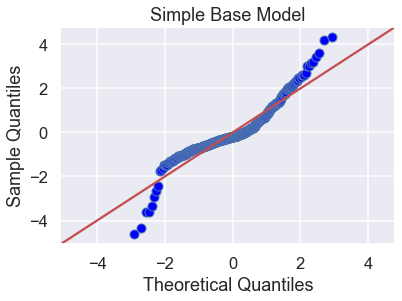

In [6]:
display.Image('Images/Base_qqplot.png')

## Model 2

For the next iteration, firstly the normalisation of the `cr` column was looked into. It was heavily skewed as per the graph below:

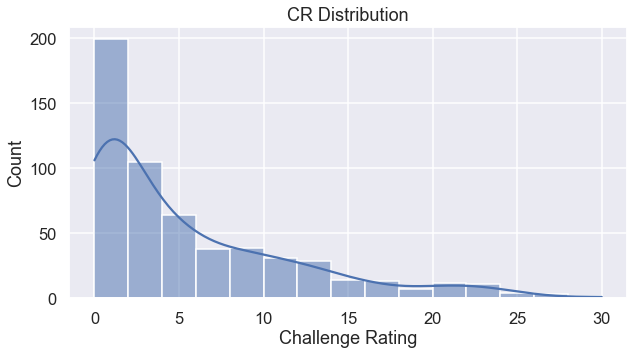

In [7]:
display.Image('Images/C_hist.png')

However thorugh visualisations of `cr` after it being log1p transformed, it did not properly normalise the distribution, and also dramatically reduced the R2 score to 0.72. Therefore this transformation was not included.

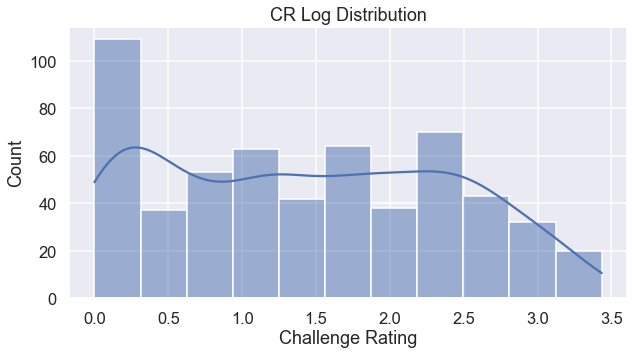

In [8]:
display.Image('Images/Clog_hist.png')

## Model 3

Then, the base stats were then added to the model. This improved the model by increasing the R2 score up to 0.90, and reducing the RMSE scores to roughly 1.9.

The distributions of `ac`, `hp`, `cha` and `intel` were shown to be not quite normally distributed, so again transformation was exprimented upon.

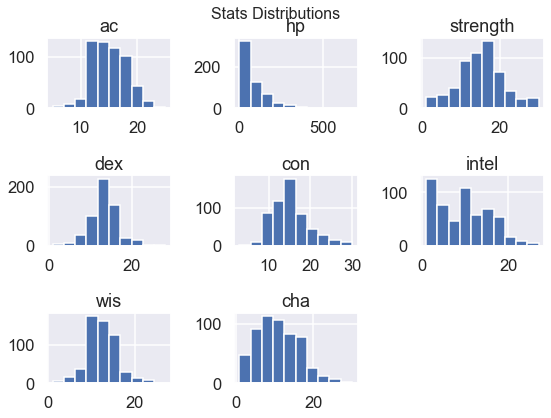

In [9]:
display.Image('Images/Stat_Dists.png')

Once again, this unfortunately brought down the R2 score to 0.78, and actually increased the RMSE slightly, so this normalisation was scrapped.

## Model 4

For the next iteration, the last numerical columns of `fly`, `swim`, `legendary`, `multiattack` were added. These variables showcased either being heavily 0 skewed, or boolean, which is why they were left until this model to implement.

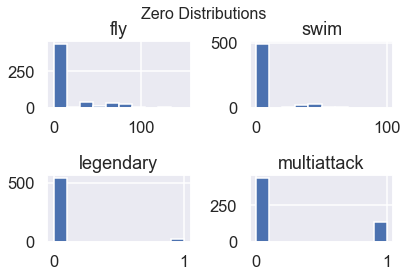

In [10]:
display.Image('Images/Zero_Dists.png')

Thankfully the model was able to account for these variables and brought the R2 score to 0.9 for both Train, Test and Adjusted, aswell as the RMSE to 1.9 for both Train and Test.

## Model 5

For the first categorical column `size`, it's values proved linear, so the column was transformed into an ordinal scale to enable regression analysis.

In [11]:
df['size'].unique()

array(['medium', 'large', 'huge', 'gargantuan', 'small', 'tiny'],
      dtype=object)

The scale was as follows:
- tiny = 1
- small = 2
- medium = 3
- large = 4
- huge = 5
- gargantuan = 6

After this transformation the iteration scores were:  
R2 Train = 0.91, R2 Test = 0.89, Adjusted R = 0.90  
RMSE Train = 1.9, RMSE Test = 2.0

## Model 6

Next the `type` categorical data was one-hot encoded using pandas dummy variables.

In [12]:
df['type'].unique()

array(['humanoid', 'aberration', 'monstrosity', 'undead', 'dragon',
       'ooze', 'elemental', 'fiend', 'beast', 'construct', 'fey', 'plant',
       'giant', 'celestial', 'swarm'], dtype=object)

For more information and descriptions of these Monster types, please visit this helpful page [here](https://www.5esrd.com/gamemastering/monsters-foes/monsters-by-type/).

This brought the R2 score back up to a resounding 0.91 across the board, with reduced RMSE scores of 1.8.

# Results

With a R2 score of 0.91, this regression analysis can successfully account for the variance of 91% of the model using a Monster's stats.  

Now that the iterations were complete with high accuracy attained, the final model was showing a better fit of Actual vs Predicted `cr` values. 

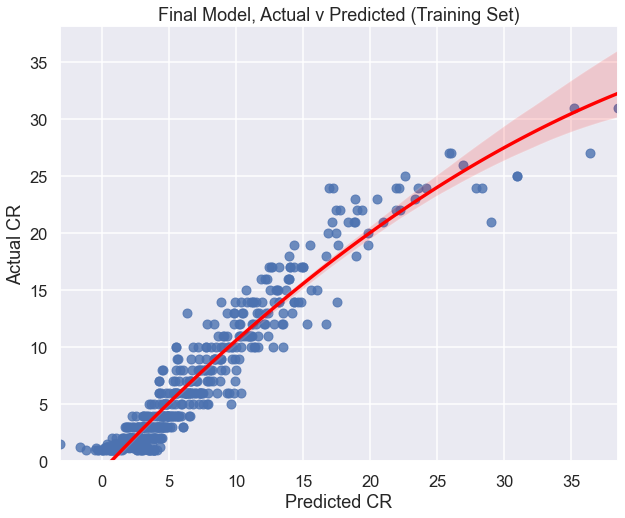

In [14]:
display.Image('Images/Final_Model.png')

There is a slight non-linear curve shown in the Train set of `cr` predicted values, which is evident in the Test set:

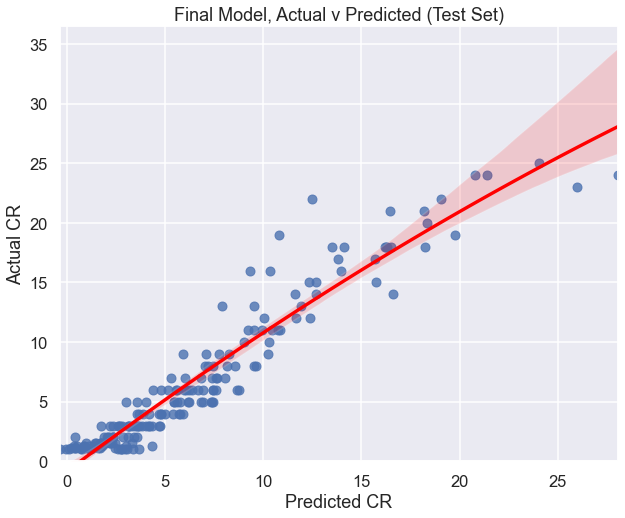

In [15]:
display.Image('Images/Final_ModelTest.png')

Using Random Forest Regressor from SkLearn, the model was able to provide inference upon what variable were most correated with `cr` as well.   
  
The top 10 were:    
1) hp  
2) intel  
3) cha  
4) ac  
5) wis  
6) strength  
7) con  
8) dex  
9) multiattack  
10) type_fiend  

With the top 5 as an example, these stats showed quite positive linear relationships with Challenge Rating, especially `hp`.

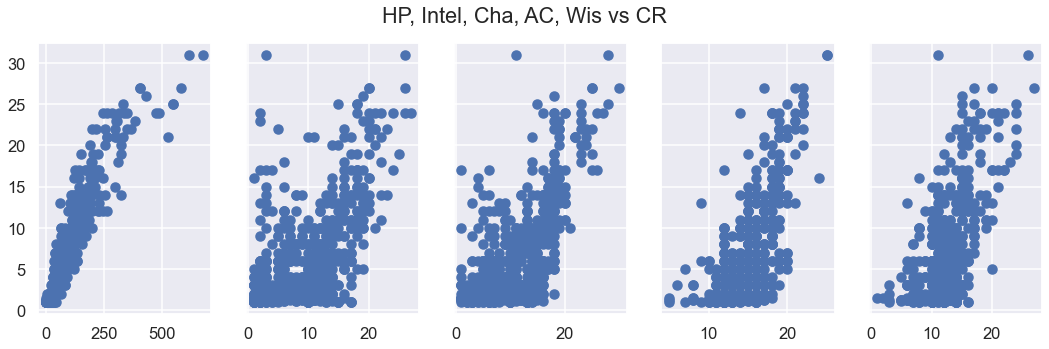

In [16]:
display.Image('Images/CR_vs_stats.png')

## Prediction CR

Fianlly, using the stats of a Home-brew Monster created on the D&D Beyond tool, the model was able to then predict and therefore calcuate what it's CR should be.

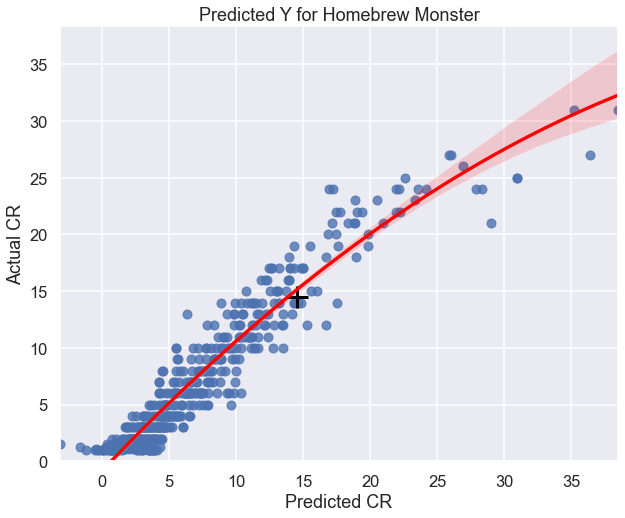

In [17]:
display.Image('Images/CR_prediction.png')

The Challenge Rating for this Monster was found to be 14, which was 4 levels higher than initially thought without this calculation/prediction  model.

# Conclusion

Based off this regression analysis, D&D Beyond may use this prediction model to implement a Challenge Rating Calculator for their Monster Creation Tool, and make it available to the online platform players.  
- Those that wish to create Home-brew Monsters with a high CR may focus on the most correlated stat scores, with the top 5 being hp, intelligence, charisma, armour class and wisdom.  
- Many have anecdotally claimed that "CR is measured only by ac and hp", and although these claims have some merit showcased within this analysis, `ac` interestingly does not have as much importance to the model as previously thought.
- The `fiend` Monster type has been shown to be the species of creature that is most correlated with CR. More analysis into reasons behind this may provide a more sophisticated understanding of why, such as whether they are particular to having multiattacks or higher stats than most other Monster types.
- As more official Dungeon & Dragons Monsters are released through game expansions, they can also be included upon the model's data-set to improve the Challenge Rating predictions.